In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [94]:
reload(medvqa.evaluation.plots)

<module 'medvqa.evaluation.plots' from '/home/pamessina/medvqa/medvqa/evaluation/plots.py'>

In [2]:
from medvqa.utils.files import load_pickle
import numpy as np
import medvqa
import os
from importlib import reload
from medvqa.evaluation.plots import visualize_predicted_bounding_boxes__yolo, plot_metrics
from medvqa.utils.constants import VINBIG_BBOX_NAMES
from medvqa.metrics.bbox.utils import compute_mAP__yolov11
from medvqa.utils.logging import print_magenta

In [3]:
# source: https://www.kaggle.com/competitions/vinbigdata-chest-xray-abnormalities-detection/data
VINBIGDATA_CHALLENGE_CLASSES = [
    'Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Nodule/Mass',
    'Other lesion',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis',
]
assert all(x in VINBIG_BBOX_NAMES for x in VINBIGDATA_CHALLENGE_CLASSES)

# source: https://github.com/philip-mueller/chex/blob/main/conf/dataset/class_names/vindrcxr_loc_top15.yaml
CHEX_CLASSES = [
    'Aortic enlargement',
    'Atelectasis',
    'Cardiomegaly',
    'Calcification',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Mediastinal shift',
    'Nodule/Mass',
    'Pulmonary fibrosis',
    'Pneumothorax',
    'Pleural thickening',
    'Pleural effusion',
    'Other lesion',
]
assert all(x in VINBIG_BBOX_NAMES for x in CHEX_CLASSES)

CHEX_IOU_THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [4]:
def compute_map_metrics_from_results(results_path, iou_thresholds = [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]):
    results = load_pickle(results_path)
    res = compute_mAP__yolov11(
        gt_coords=results['gt_bboxes'],
        pred_boxes=results['pred_boxes_list'],
        pred_classes=results['pred_classes_list'],
        pred_confs=results['pred_confs_list'],
        iou_thresholds=iou_thresholds,
        compute_micro_average=True,
    )
    class_aps = res['class_aps']
    micro_aps = res['micro_aps']
        
    for iou_thresh, map_ in zip(iou_thresholds, class_aps.mean(axis=1)):
        print_magenta(f'mAP@{iou_thresh}: {map_}', bold=True)

    for iou_thresh, ap in zip(iou_thresholds, micro_aps):
        print_magenta(f'micro_AP@{iou_thresh}: {ap}', bold=True)
        
    # vinbigdata metric
    class_idxs = [VINBIG_BBOX_NAMES.index(x) for x in VINBIGDATA_CHALLENGE_CLASSES]
    iou_idx = iou_thresholds.index(0.4)
    mAP = class_aps[iou_idx, class_idxs].mean()
    print_magenta(f'vinbigdata mAP@0.4: {mAP}', bold=True)

    # ChEX metric
    class_idxs = [VINBIG_BBOX_NAMES.index(x) for x in CHEX_CLASSES]
    iou_idxs = [iou_thresholds.index(x) for x in CHEX_IOU_THRESHOLDS]
    mAP = class_aps[iou_idxs][:, class_idxs].mean()
    print_magenta(f'ChEX mAP@{CHEX_IOU_THRESHOLDS}: {mAP}', bold=True)

# 1) YOLOv11 (trained on VinDrCXR)

In [40]:
!python ../eval_modified_yolov11.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)" \
--batch_size 200 \
--num_workers 3 \
--eval_vinbig \
--use_amp

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)
   batch_size: 200
   num_workers: 3
   device: GPU
   eval_vinbig: True
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 100
   use_amp: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: yolov11-for-det-mlc

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ul

In [14]:
!python ../eval_modified_yolov11.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)" \
--batch_size 200 \
--num_workers 3 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--eval_vinbig \
--use_amp

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)
   batch_size: 200
   num_workers: 3
   device: GPU
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 100
   use_amp: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: yolov11-for-det-mlc

                   from  n    params  module                                       argument

conf_th=0.4, iou_th=0.02, mAP=0.03193939393939394 (time_input_processing=0.6720566749572754, time_map=0.743537425994873)
conf_th=0.4, iou_th=0.05, mAP=0.03193939393939394 (time_input_processing=0.711143970489502, time_map=1.069746494293213)
conf_th=0.4, iou_th=0.1, mAP=0.03213310616251793 (time_input_processing=0.7115142345428467, time_map=1.0869140625)
conf_th=0.4, iou_th=0.2, mAP=0.03496113731064744 (time_input_processing=0.6702237129211426, time_map=1.1421942710876465)
conf_th=0.4, iou_th=0.3, mAP=0.05415184736931164 (time_input_processing=0.6698808670043945, time_map=1.1753802299499512)
conf_th=0.4, iou_th=0.4, mAP=0.09146235086861662 (time_input_processing=0.6693744659423828, time_map=0.48137903213500977)
conf_th=0.4, iou_th=0.5, mAP=0.06742198827116556 (time_input_processing=0.9196782112121582, time_map=0.48687028884887695)
conf_th=0.5, iou_th=0.02, mAP=0.03414972358722359 (time_input_processing=0.6285371780395508, time_map=0.3901553153991699)
conf_th=0.5, iou_th=0.05, mAP=0.0319

In [43]:
!python ../eval_modified_yolov11.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)" \
--batch_size 200 \
--num_workers 3 \
--optimize_thresholds \
--candidate_iou_thresholds 0.01 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--max_det 200 \
--eval_vinbig \
--use_amp

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)
   batch_size: 200
   num_workers: 3
   device: GPU
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 200
   use_amp: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: yolov11-for-det-mlc

                   from  n    params  module                                       ar

conf_th=0.3, iou_th=0.2, mAP=0.03193939393939394 (time_input_processing=0.750540018081665, time_map=0.5089523792266846)
conf_th=0.3, iou_th=0.3, mAP=0.03193939393939394 (time_input_processing=0.749793291091919, time_map=1.0593607425689697)
conf_th=0.3, iou_th=0.4, mAP=0.03193939393939394 (time_input_processing=0.7457892894744873, time_map=1.5202362537384033)
conf_th=0.3, iou_th=0.5, mAP=0.03203419328419329 (time_input_processing=0.7485737800598145, time_map=1.5594489574432373)
conf_th=0.4, iou_th=0.01, mAP=0.035173858007104764 (time_input_processing=0.710355281829834, time_map=1.1138432025909424)
conf_th=0.4, iou_th=0.02, mAP=0.05510742038706611 (time_input_processing=0.7110123634338379, time_map=1.16990327835083)
conf_th=0.4, iou_th=0.05, mAP=0.09371000786499974 (time_input_processing=0.6660027503967285, time_map=0.7185750007629395)
conf_th=0.4, iou_th=0.1, mAP=0.06830533390612852 (time_input_processing=0.6668577194213867, time_map=0.4705531597137451)
conf_th=0.4, iou_th=0.2, mAP=0.03

In [49]:
!python ../eval_modified_yolov11.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)" \
--batch_size 200 \
--num_workers 3 \
--optimize_thresholds \
--candidate_conf_thresholds 0.01 0.025 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_iou_thresholds 0.01 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--max_det 200 \
--eval_vinbig \
--use_amp

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)
   batch_size: 200
   num_workers: 3
   device: GPU
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 200
   use_amp: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: yolov11-for-det-mlc

                   from  n    params  module                                

conf_th=0.05, iou_th=0.2, mAP=0.1729598781074115 (time_input_processing=1.1638267040252686, time_map=1.0789968967437744)
conf_th=0.05, iou_th=0.3, mAP=0.16305926548882674 (time_input_processing=1.1178278923034668, time_map=1.1184327602386475)
conf_th=0.05, iou_th=0.4, mAP=0.1582365599795936 (time_input_processing=1.1641273498535156, time_map=1.1871705055236816)
conf_th=0.05, iou_th=0.5, mAP=0.15180792408428362 (time_input_processing=1.115746021270752, time_map=1.2902634143829346)
conf_th=0.1, iou_th=0.01, mAP=0.1622953481281803 (time_input_processing=1.2798120975494385, time_map=0.8786144256591797)
conf_th=0.1, iou_th=0.02, mAP=0.16242818748778637 (time_input_processing=0.9812426567077637, time_map=0.8699300289154053)
conf_th=0.1, iou_th=0.05, mAP=0.16246662703856976 (time_input_processing=1.0267119407653809, time_map=0.8680121898651123)
conf_th=0.1, iou_th=0.1, mAP=0.16328856625704238 (time_input_processing=1.0339241027832031, time_map=0.8802645206451416)
conf_th=0.1, iou_th=0.2, mAP=

In [9]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.10,0.03,200)).pkl')

mAP@0.0: 0.25541011567645844
mAP@0.02: 0.24012123860142207
mAP@0.05: 0.2323955646718607
mAP@0.1: 0.2142200227092902
mAP@0.2: 0.18217193553937572
mAP@0.3: 0.14828449356671916
mAP@0.4: 0.12501061707349728
mAP@0.5: 0.09771582918977754
mAP@0.6: 0.07295559651226752
mAP@0.7: 0.051178678633152556
micro_AP@0.0: 0.3339930523012514
micro_AP@0.02: 0.3128062357184258
micro_AP@0.05: 0.30200653399765415
micro_AP@0.1: 0.28122897953446563
micro_AP@0.2: 0.24250382335726683
micro_AP@0.3: 0.21036054175992555
micro_AP@0.4: 0.18275625393393938
micro_AP@0.5: 0.1565886333357622
micro_AP@0.6: 0.11838571305296314
micro_AP@0.7: 0.07259499064855844
vinbigdata mAP@0.4: 0.17179136391560904
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.1803735819863521


In [86]:
!python ../eval_modified_yolov11.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)" \
--batch_size 200 \
--num_workers 3 \
--optimize_thresholds \
--candidate_conf_thresholds 0.025 \
--candidate_iou_thresholds 0.1 \
--max_det 200 \
--eval_vinbig \
--vinbig_use_training_indices_for_validation \
--use_amp

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)
   batch_size: 200
   num_workers: 3
   device: GPU
   vinbig_use_training_indices_for_validation: True
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.1]
   candidate_conf_thresholds: [0.025]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 200
   use_amp: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: yolov11-for-det-mlc

                   from  n    params  module                                       arguments       

In [108]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)/vindrcxr_metrics(bbox_regression,15000,opt_thr(0.10,0.03,200)).pkl')

mAP@0.0: 0.5586788607741378
mAP@0.02: 0.5421477615710664
mAP@0.05: 0.5371340955375675
mAP@0.1: 0.5267448528511858
mAP@0.2: 0.49744659782932776
mAP@0.3: 0.46606128655761464
mAP@0.4: 0.4293065583109339
mAP@0.5: 0.3850567266726619
micro_AP@0.0: 0.6871866075111495
micro_AP@0.02: 0.6640109139936454
micro_AP@0.05: 0.6565855511949946
micro_AP@0.1: 0.6427550881538124
micro_AP@0.2: 0.6103702395043912
micro_AP@0.3: 0.5737393717779529
micro_AP@0.4: 0.5345482423296684
micro_AP@0.5: 0.4922501441002091


In [12]:
!python ../eval_modified_yolov11.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20250216_150203_vinbig_yolo11l(d:vinbig)" \
--batch_size 200 \
--num_workers 3 \
--optimize_thresholds \
--candidate_conf_thresholds 0.01 0.025 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_iou_thresholds 0.01 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--max_det 200 \
--eval_vinbig \
--use_amp

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20250216_150203_vinbig_yolo11l(d:vinbig)
   batch_size: 200
   num_workers: 3
   device: GPU
   vinbig_use_training_indices_for_validation: False
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   max_det: 200
   use_amp: True
Activating determinism(seed=42)...
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20250216_150203_vinbig_yolo11l(d:vinbig)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder:

conf_th=0.05, iou_th=0.1, mAP=0.18090678709145488 (time_input_processing=2.348694086074829, time_map=1.210353136062622)
conf_th=0.05, iou_th=0.2, mAP=0.1752460659421685 (time_input_processing=2.4551711082458496, time_map=1.177692174911499)
conf_th=0.05, iou_th=0.3, mAP=0.16675903444829293 (time_input_processing=1.502457618713379, time_map=1.252856731414795)
conf_th=0.05, iou_th=0.4, mAP=0.1621288300033047 (time_input_processing=2.2683000564575195, time_map=1.3753952980041504)
conf_th=0.05, iou_th=0.5, mAP=0.1551813756995376 (time_input_processing=1.8481395244598389, time_map=1.5265681743621826)
conf_th=0.1, iou_th=0.01, mAP=0.17123343497053123 (time_input_processing=1.8574342727661133, time_map=0.987274169921875)
conf_th=0.1, iou_th=0.02, mAP=0.1714422464226257 (time_input_processing=1.365189790725708, time_map=0.9694244861602783)
conf_th=0.1, iou_th=0.05, mAP=0.17166457106055477 (time_input_processing=2.0679104328155518, time_map=0.9602837562561035)
conf_th=0.1, iou_th=0.1, mAP=0.1720

Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/visual_module/20250216_150203_vinbig_yolo11l(d:vinbig)/vindrcxr_metrics(detection,3000,opt_thr(0.01,0.03,200)).pkl


In [7]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/visual_module/20250216_150203_vinbig_yolo11l(d:vinbig)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.05,0.03,200)).pkl')

mAP@0.0: 0.2623704253493755
mAP@0.02: 0.24425357284492594
mAP@0.05: 0.2372904805150057
mAP@0.1: 0.22662410174443748
mAP@0.2: 0.19045697899084546
mAP@0.3: 0.15878474603827183
mAP@0.4: 0.13070317201156093
mAP@0.5: 0.10767596532043176
mAP@0.6: 0.08497397110557342
mAP@0.7: 0.055414464478171784
micro_AP@0.0: 0.33824160630035327
micro_AP@0.02: 0.3152591986082153
micro_AP@0.05: 0.3057202596814322
micro_AP@0.1: 0.2911439769191875
micro_AP@0.2: 0.25469916624002226
micro_AP@0.3: 0.22350216332792283
micro_AP@0.4: 0.19116806362967642
micro_AP@0.5: 0.1666283130389326
micro_AP@0.6: 0.13072869801072723
micro_AP@0.7: 0.07748411031249505
vinbigdata mAP@0.4: 0.1838630297551085
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.19329621425769658


In [10]:
tmp = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/visual_module/20241123_031630_vinbig_yolo11l(d:vinbig)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.10,0.03,200)).pkl')

In [11]:
tmp.keys()

dict_keys(['image_paths', 'pred_boxes_list', 'pred_classes_list', 'pred_confs_list', 'gt_bboxes', 'class_ious', 'sample_ious', 'micro_iou', 'macro_iou', 'map_iou_thresholds', 'map_per_class', 'best_iou_threshold', 'best_conf_threshold', 'max_det'])

In [54]:
idxs = np.argsort(tmp['sample_ious'])[::-1]

0.06768125


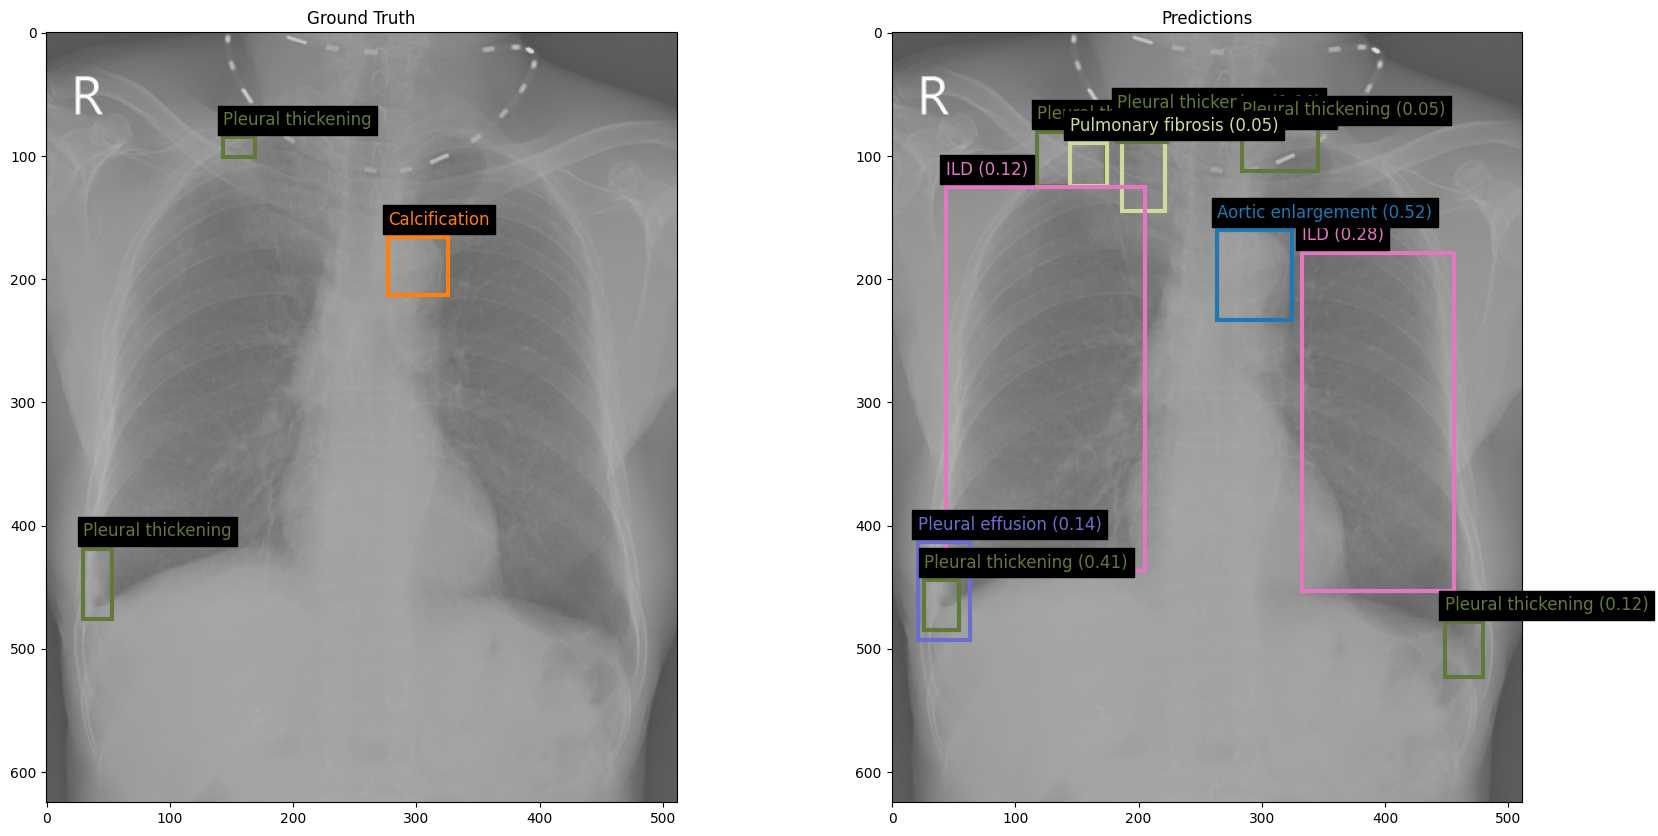

In [84]:
i = 804
i = idxs[i]
print(tmp['sample_ious'][i])
visualize_predicted_bounding_boxes__yolo(
    image_path=tmp['image_paths'][i],
    pred_coords=tmp['pred_boxes_list'][i],
    pred_classes=tmp['pred_classes_list'][i],
    pred_confs=tmp['pred_confs_list'][i],
    gt_bbox_coords=tmp['gt_bboxes'][i],
    class_names=VINBIG_BBOX_NAMES,
    figsize=(20, 10),
    format='xyxy',
)

In [15]:
from medvqa.datasets.vinbig import compute_label_frequencies

label_frequencies = compute_label_frequencies()

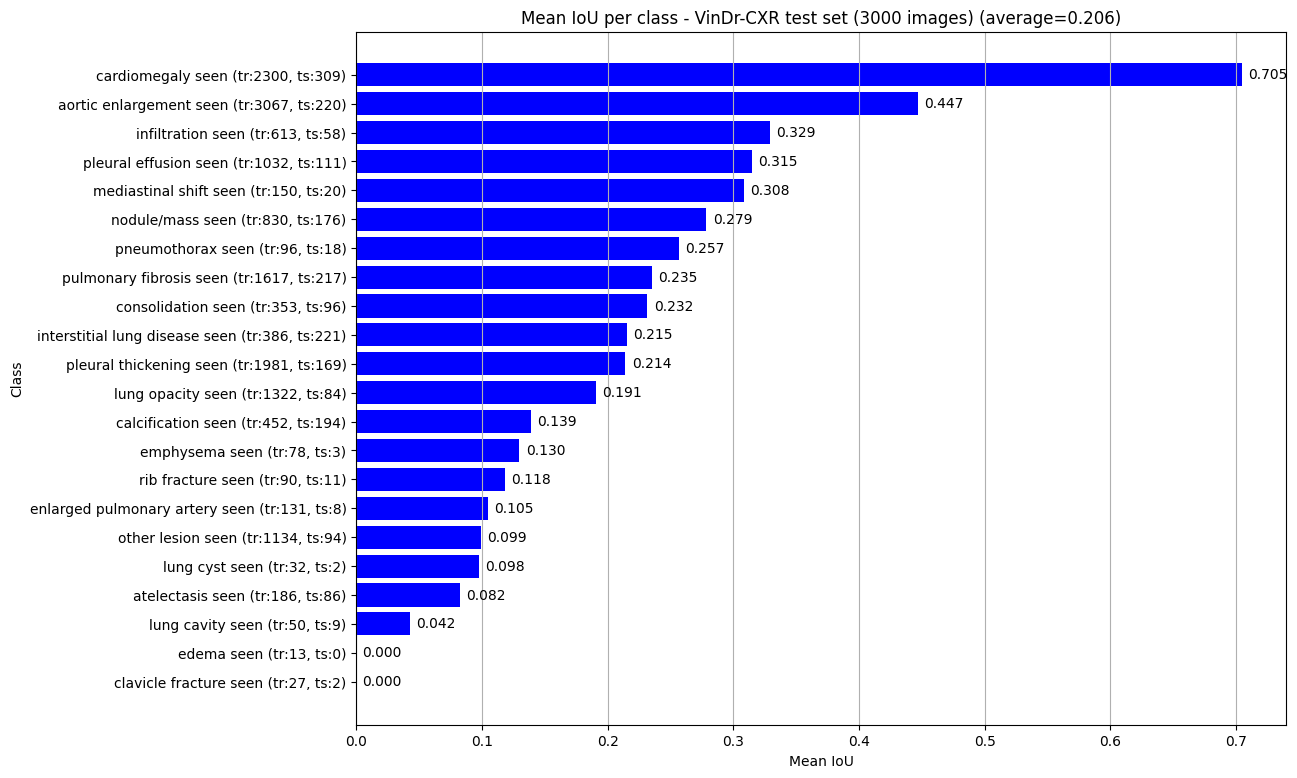

In [16]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

plot_metrics(
    metric_names=[f'{VINBIG_LABEL2PHRASE[x]} (tr:{label_frequencies["train"][x]}, ts:{label_frequencies["test"][x]})' for x in VINBIG_BBOX_NAMES],
    metric_values=tmp['class_ious'],
    title='Mean IoU per class - VinDr-CXR test set (3000 images)',
    ylabel='Class',
    xlabel='Mean IoU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 9),
    append_average_to_title=True,
)

# 2) YOLOv11 (trained on VinDrCXR + Chest ImaGenome)

In [50]:
!python ../eval_modified_yolov11.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241122_163237_mim+vinbig_yolo11l(d:cig,vinbig)_dws=1,0.3" \
--batch_size 200 \
--num_workers 3 \
--optimize_thresholds \
--candidate_conf_thresholds 0.01 0.025 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_iou_thresholds 0.01 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--max_det 200 \
--eval_vinbig \
--use_amp

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241122_163237_mim+vinbig_yolo11l(d:cig,vinbig)_dws=1,0.3
   batch_size: 200
   num_workers: 3
   device: GPU
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 200
   use_amp: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241122_163237_mim+vinbig_yolo11l(d:cig,vinbig)_dws=1,0.3/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: yolov11-for-det-mlc

                   from  n    params  mo

  Loaded 18000 bounding boxes
Generating train dataset and dataloader
len(self.test_indices) = 3000
Creating evaluation engine ...
get_engine(): shift_answer=False
chest_imagenome_bbox_loss_weight:  1.0
--------------------------------------------------
6) Defining log_metrics_handler ...
--------------------------------------------------
7) Running engine ...
15.76 secs
--------------------------------------------------
8) Computing metrics ...
yolov11_predictions[0].shape = torch.Size([200, 26, 3549])
resized_shapes[0][0] = [416, 416]
Finding optimal conf and iou thresholds
conf_th=0.01, iou_th=0.01, mAP=0.1206176991002562 (time_input_processing=2.010643482208252, time_map=1.3005082607269287)
conf_th=0.01, iou_th=0.02, mAP=0.12077039243559207 (time_input_processing=1.8372607231140137, time_map=1.564382791519165)
conf_th=0.01, iou_th=0.05, mAP=0.12030185607099045 (time_input_processing=1.8611774444580078, time_map=1.343224048614502)
conf_th=0.01, iou_th=0.1, mAP=0.11943591842884303 (t

conf_th=0.5, iou_th=0.4, mAP=0.07414961499404919 (time_input_processing=0.6612770557403564, time_map=0.355623722076416)
conf_th=0.5, iou_th=0.5, mAP=0.0741061037196306 (time_input_processing=0.6157691478729248, time_map=0.3539268970489502)
best_iou_threshold: 0.02
best_conf_threshold: 0.025
mean_iou(Aortic enlargement): 0.378494530916214 (220 samples)
mean_iou(Atelectasis): 0.04357149824500084 (86 samples)
mean_iou(Calcification): 0.020068641752004623 (194 samples)
mean_iou(Cardiomegaly): 0.6418164968490601 (309 samples)
mean_iou(Clavicle fracture): 0.0 (2 samples)
mean_iou(Consolidation): 0.133316770195961 (96 samples)
mean_iou(Edema): 0.0 (0 samples)
mean_iou(Emphysema): 0.2990184724330902 (3 samples)
mean_iou(Enlarged PA): 0.09645049273967743 (8 samples)
mean_iou(ILD): 0.11725761741399765 (221 samples)
mean_iou(Infiltration): 0.17659679055213928 (58 samples)
mean_iou(Lung Opacity): 0.09629225730895996 (84 samples)
mean_iou(Lung cavity): 0.0189471747726202 (9 samples)
mean_iou(Lung c

In [8]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/visual_module/20241122_163237_mim+vinbig_yolo11l(d:cig,vinbig)_dws=1,0.3/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.02,0.03,200)).pkl')

mAP@0.0: 0.1765874727636268
mAP@0.02: 0.16156928001667412
mAP@0.05: 0.15721029678165138
mAP@0.1: 0.14974386334983095
mAP@0.2: 0.12527815764978245
mAP@0.3: 0.10677567112872616
mAP@0.4: 0.08635633130899445
mAP@0.5: 0.0737074873107252
mAP@0.6: 0.0625438784470136
mAP@0.7: 0.04554443362180143
micro_AP@0.0: 0.20785508997691293
micro_AP@0.02: 0.1921845381067307
micro_AP@0.05: 0.18652418661338735
micro_AP@0.1: 0.17814216439069447
micro_AP@0.2: 0.15868997261423357
micro_AP@0.3: 0.14382672667892962
micro_AP@0.4: 0.12353628941120845
micro_AP@0.5: 0.10623198003479985
micro_AP@0.6: 0.0865506735278849
micro_AP@0.7: 0.053109878179259246
vinbigdata mAP@0.4: 0.11496932214134988
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.13154508884199095


In [90]:
tmp = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/visual_module/20241122_163237_mim+vinbig_yolo11l(d:cig,vinbig)_dws=1,0.3/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.02,0.03,200)).pkl')

In [91]:
tmp.keys()

dict_keys(['image_paths', 'pred_boxes_list', 'pred_classes_list', 'pred_confs_list', 'gt_bboxes', 'class_ious', 'sample_ious', 'micro_iou', 'macro_iou', 'map_iou_thresholds', 'map_per_class', 'best_iou_threshold', 'best_conf_threshold', 'max_det'])

In [92]:
idxs = np.argsort(tmp['sample_ious'])[::-1]

0.83933824
image_path=/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/8a56a454dfea716a4d249144054974c1.jpg


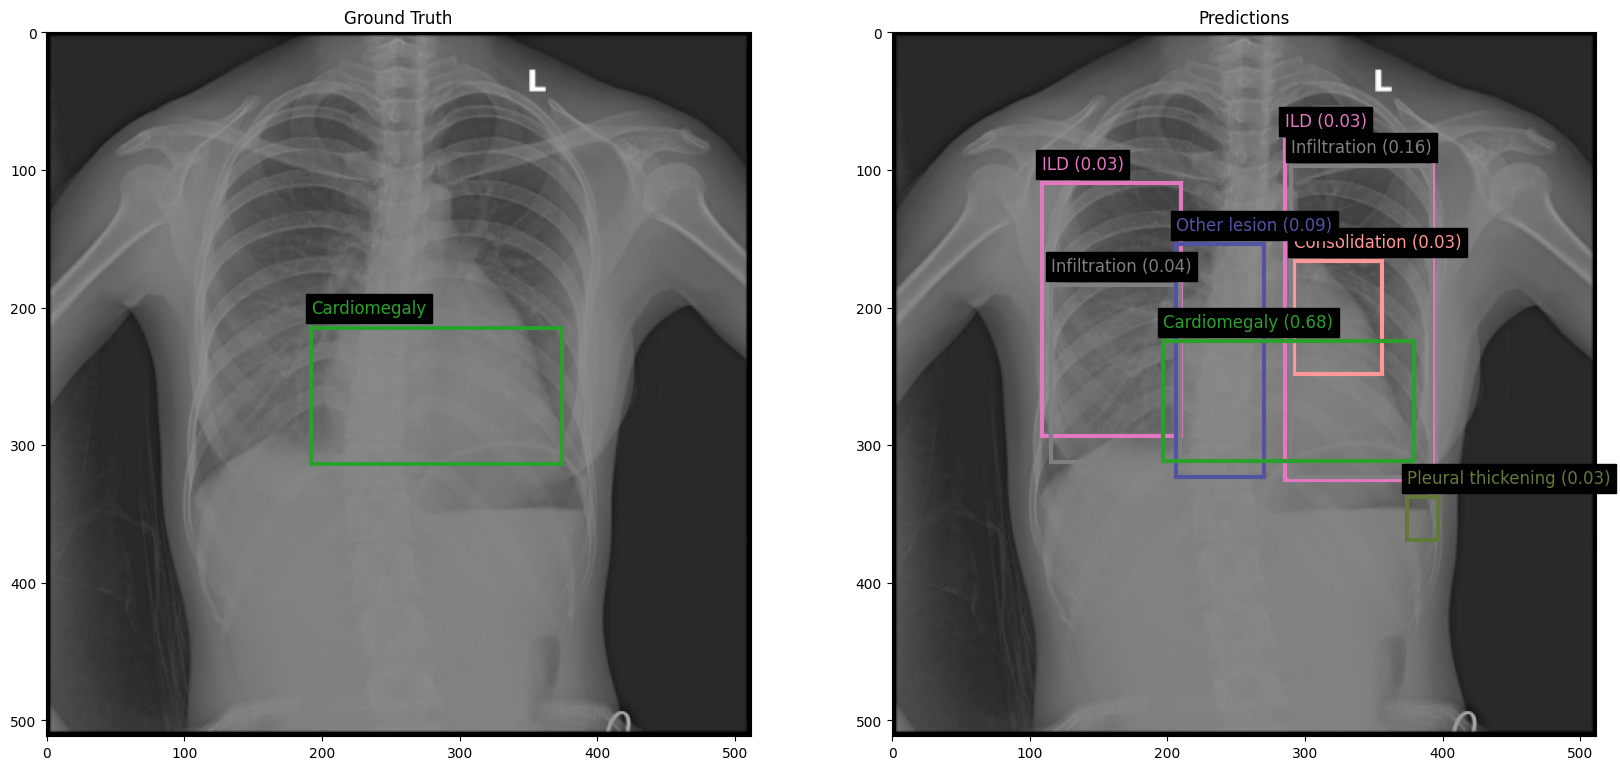

In [97]:
i = 1
i = idxs[i]
print(tmp['sample_ious'][i])
visualize_predicted_bounding_boxes__yolo(
    image_path=tmp['image_paths'][i],
    pred_coords=tmp['pred_boxes_list'][i],
    pred_classes=tmp['pred_classes_list'][i],
    pred_confs=tmp['pred_confs_list'][i],
    gt_bbox_coords=tmp['gt_bboxes'][i],
    class_names=VINBIG_BBOX_NAMES,
    figsize=(20, 10),
    format='xyxy',
)

# 3) YOLOv8 (trained on VinDrCXR + Chest ImaGenome)

In [51]:
!python ../eval_modified_yolov11.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241122_211226_mim+vinbig_yolov8l(d:cig,vinbig)_dws=1,0.3" \
--batch_size 200 \
--num_workers 3 \
--optimize_thresholds \
--candidate_conf_thresholds 0.01 0.025 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_iou_thresholds 0.01 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--max_det 200 \
--eval_vinbig \
--use_amp

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241122_211226_mim+vinbig_yolov8l(d:cig,vinbig)_dws=1,0.3
   batch_size: 200
   num_workers: 3
   device: GPU
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 200
   use_amp: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241122_211226_mim+vinbig_yolov8l(d:cig,vinbig)_dws=1,0.3/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: yolov11-for-det-mlc
Overriding model.yaml nc=80 with nc=36

 

15.58 secs
--------------------------------------------------
8) Computing metrics ...
yolov11_predictions[0].shape = torch.Size([200, 26, 3549])
resized_shapes[0][0] = [416, 416]
Finding optimal conf and iou thresholds
conf_th=0.01, iou_th=0.01, mAP=0.1615184882720742 (time_input_processing=1.5243866443634033, time_map=0.9633622169494629)
conf_th=0.01, iou_th=0.02, mAP=0.1610305223136265 (time_input_processing=1.458817958831787, time_map=0.9725677967071533)
conf_th=0.01, iou_th=0.05, mAP=0.1597532359062771 (time_input_processing=1.4513847827911377, time_map=0.9799010753631592)
conf_th=0.01, iou_th=0.1, mAP=0.15906171733928592 (time_input_processing=1.4996860027313232, time_map=0.9947924613952637)
conf_th=0.01, iou_th=0.2, mAP=0.1559573317161217 (time_input_processing=1.4952378273010254, time_map=1.0444958209991455)
conf_th=0.01, iou_th=0.3, mAP=0.1495741598190395 (time_input_processing=1.4550166130065918, time_map=1.100557804107666)
conf_th=0.01, iou_th=0.4, mAP=0.14614039845330226 (t

mAP@0.0: 0.21939130737903742
mAP@0.02: 0.20304340268619647
mAP@0.05: 0.19927242950559398
mAP@0.1: 0.19020456284365161
mAP@0.2: 0.16173186188430802
mAP@0.3: 0.13759439754724004
mAP@0.4: 0.12376454703855452
mAP@0.5: 0.1013692710540657
Saving metrics to file ...
Saved metrics to /mnt/data/pamessina/workspaces/medvqa-workspace/results/visual_module/20241122_211226_mim+vinbig_yolov8l(d:cig,vinbig)_dws=1,0.3/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.01,0.01,200)).pkl


In [6]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/visual_module/20241122_211226_mim+vinbig_yolov8l(d:cig,vinbig)_dws=1,0.3/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.01,0.01,200)).pkl')

mAP@0.0: 0.21939130737903742
mAP@0.02: 0.20304340268619647
mAP@0.05: 0.19927242950559398
mAP@0.1: 0.19020456284365161
mAP@0.2: 0.16173186188430802
mAP@0.3: 0.13759439754724004
mAP@0.4: 0.12376454703855452
mAP@0.5: 0.1013692710540657
mAP@0.6: 0.07249380190474358
mAP@0.7: 0.04954245548687113
micro_AP@0.0: 0.27169127777642244
micro_AP@0.02: 0.24630807308658004
micro_AP@0.05: 0.23870965547269535
micro_AP@0.1: 0.22733175842454467
micro_AP@0.2: 0.19584487708074683
micro_AP@0.3: 0.17033019612557887
micro_AP@0.4: 0.14781478589772418
micro_AP@0.5: 0.12430720886465213
micro_AP@0.6: 0.09380822243439099
micro_AP@0.7: 0.053901861896869116
vinbigdata mAP@0.4: 0.15581237948035767
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.1545918868676438


# 4) YOLOv8 (trained on VinDrCXR)

In [76]:
!python ../eval_modified_yolov11.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241129_083600_vinbig_yolov8l(d:vinbig)" \
--batch_size 200 \
--num_workers 3 \
--optimize_thresholds \
--candidate_conf_thresholds 0.01 0.025 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_iou_thresholds 0.01 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--max_det 200 \
--eval_vinbig \
--use_amp

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241129_083600_vinbig_yolov8l(d:vinbig)
   batch_size: 200
   num_workers: 3
   device: GPU
   eval_vinbig: True
   optimize_thresholds: True
   candidate_iou_thresholds: [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 200
   use_amp: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/visual_module/20241129_083600_vinbig_yolov8l(d:vinbig)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: yolov11-for-det-mlc
Overriding model.yaml nc=80 with nc=22

                   from  n    params 

conf_th=0.05, iou_th=0.3, mAP=0.1514008918137669 (time_input_processing=1.0119774341583252, time_map=0.960852861404419)
conf_th=0.05, iou_th=0.4, mAP=0.14772785799511892 (time_input_processing=1.0109138488769531, time_map=1.2416183948516846)
conf_th=0.05, iou_th=0.5, mAP=0.14550171392114117 (time_input_processing=1.0557539463043213, time_map=1.0548241138458252)
conf_th=0.1, iou_th=0.01, mAP=0.154086172269722 (time_input_processing=0.906752347946167, time_map=0.7892813682556152)
conf_th=0.1, iou_th=0.02, mAP=0.15409521569903173 (time_input_processing=0.9076023101806641, time_map=0.7774176597595215)
conf_th=0.1, iou_th=0.05, mAP=0.15367188861752182 (time_input_processing=0.9050412178039551, time_map=0.7849106788635254)
conf_th=0.1, iou_th=0.1, mAP=0.15339281663357676 (time_input_processing=0.9505307674407959, time_map=0.7828507423400879)
conf_th=0.1, iou_th=0.2, mAP=0.15168143305367296 (time_input_processing=0.9521465301513672, time_map=0.7921297550201416)
conf_th=0.1, iou_th=0.3, mAP=0.

In [5]:
compute_map_metrics_from_results('/mnt/data/pamessina/workspaces/medvqa-workspace/results/visual_module/20241129_083600_vinbig_yolov8l(d:vinbig)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.05,0.01,200)).pkl')

mAP@0.0: 0.24454460218482454
mAP@0.02: 0.22554081584491997
mAP@0.05: 0.2195368643059014
mAP@0.1: 0.20535127668445552
mAP@0.2: 0.17582316116231736
mAP@0.3: 0.1437433553168988
mAP@0.4: 0.11730364435458877
mAP@0.5: 0.09507851156400887
mAP@0.6: 0.06736556048573067
mAP@0.7: 0.048809881020019145
micro_AP@0.0: 0.30280705617981757
micro_AP@0.02: 0.27625552262006103
micro_AP@0.05: 0.2682404891517562
micro_AP@0.1: 0.24962347988885003
micro_AP@0.2: 0.2139181135826281
micro_AP@0.3: 0.1837448492768089
micro_AP@0.4: 0.15623943456804634
micro_AP@0.5: 0.1296035530114862
micro_AP@0.6: 0.09602097526523871
micro_AP@0.7: 0.05765540533544978
vinbigdata mAP@0.4: 0.15226882208102044
ChEX mAP@[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: 0.16183640905524554
